<a href="https://colab.research.google.com/github/Oldieee/POO/blob/master/Copy_of_antrenarea_re%C8%9Belelor_pentru_regresie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h2> Antrenarea unei rețele pentru regresie <h2> </center>

Prima dată vom face import modulelor pe care le vom folosi în antrenarea modelelor dar și în vizualizarea / preprocesarea datelor.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Tensorflow** este un modul, foarte popular în Python, folosit pentru calcule care implică un volum de date foarte mare. Acesta folosește API-ul **keras** pentru a putea construi rețele neuronale artificiale.

Descărcăm datele. De data asta încercăm să prezicem consumul autovehiculelor (măsurat aici in mile pe oră - MPG).

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

Putem vizualiza datele, biblioteca *pandas* poate crea obiecte numite *dataframes* care stochează date sub formă de tabel.

In [ ]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Verificăm dacă și câte valori de tipul NaN sunt în acest dataframe și dacă sunt le putem arunca din acesta.

In [ ]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


In [ ]:
dataset = dataset.dropna()

Coloana "Origin" are doar numere, fiecare reprezentând o anumită țară / zonă / continent / etc. Le putem separa, transformând această coloană în mai multe coloane, fiecare reprezentând câte o zonă.

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='', dtype=int)
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Separăm datele în două seturi: antrenare și testare.

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Putem și trebuie să inspectăm datele înainte de antrenare, astfel identificăm relațiile dintre diversele caracteristici ale setului de date.

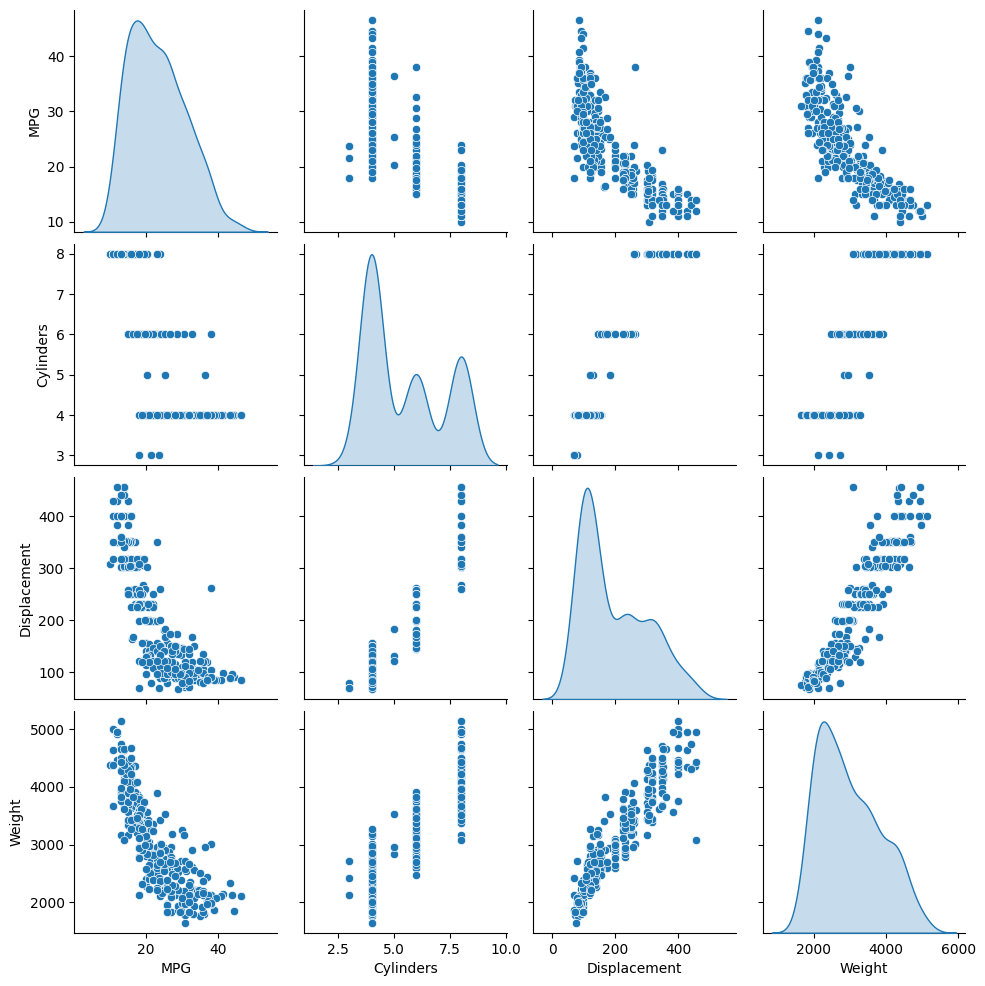

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


Separăm datele de intrare de cele pe care trebuie să le prezicem și le normalizăm.

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [ ]:
train_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0


In [ ]:
for col in train_features.columns:
  train_features[col] = train_features[col] / train_features[col].max()
  test_features[col] = test_features[col] / test_features[col].max()

In [ ]:
train_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,0.5,0.197802,0.333333,0.413424,0.584677,0.902439,0.0,0.0,1.0
282,0.5,0.307692,0.391111,0.562257,0.697581,0.963415,0.0,0.0,1.0
69,1.0,0.769231,0.711111,0.866926,0.544355,0.878049,0.0,0.0,1.0
378,0.5,0.230769,0.280000,0.413424,0.592742,1.000000,0.0,0.0,1.0
331,0.5,0.213187,0.297778,0.417315,0.725806,0.975610,0.0,1.0,0.0


**De ce normalizăm?** <br>
Pentru că putem întâlni situații în care avem o caracteristică cu valori între 2 si 10 spre exemplu și alta cu valori între 5000 și 10000. Dacă nu facem normalizare, valorile mari vor forța modelul să creadă că ele sunt mai importante, așadar caracteristica cu valori între 5000 și 10000 va fi considerată mai importantă pentru predicții, dar poate că e fix invers în realitate.

Vom crea un model acum, o vom face de data aceasta printr-o funcție care ne returnează modelul.

In [ ]:
def build_and_compile_model():
  inputs = keras.Input(shape=(len(train_features.columns),))

  x = layers.Dense(512, activation="relu", name="dense_1")(inputs)
  x = layers.Dense(256, activation="relu", name="dense_2")(x)

  outputs = layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
      loss='mean_absolute_error',
      optimizer=tf.keras.optimizers.Adam(0.001))

  return model

Bineînțeles că trebuie apoi să și apelăm funcția, ca să ne primim modelul de la ea.

In [ ]:
dnn_model = build_and_compile_model()
dnn_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,705 (534.00 KB)

 Trainable params: 136,705 (534.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=150)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 22.7750 - val_loss: 21.5361
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 20.0475 - val_loss: 17.2923
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.1635 - val_loss: 10.5245
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.6857 - val_loss: 8.6587
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.6517 - val_loss: 7.7826
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4006 - val_loss: 6.6130
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3176 - val_loss: 5.6776
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7039 - val_loss: 5.0478
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5254 - val_loss: 4.6624
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0900 - val_loss: 4.3248
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.1090 - val_loss: 4.0947
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0311 - 

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

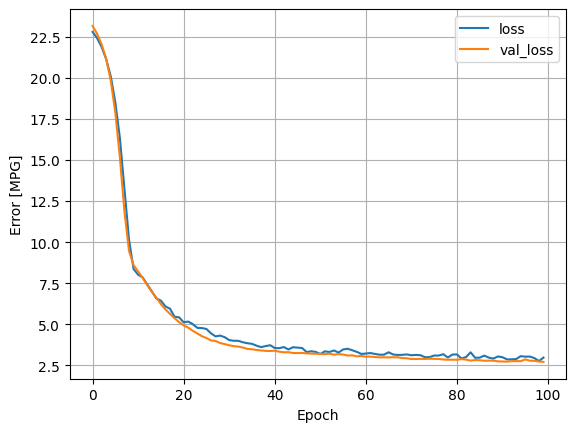

In [ ]:
plot_loss(history)

In [ ]:
predictions = dnn_model.predict(test_features)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Trebuie să verificăm performanța modelului, de data asta nu vom mai avea acuratețe, pentru că nu mai clasificăm ci trebuie să măsurăm eroarea dintre predicții și măsurători.

In [ ]:
print(f'First three predictions are {predictions[:3].squeeze()} and first three labels are {test_labels.values[:3]}')

First three predictions are [12.98  12.921 13.54 ] and first three labels are [15. 10.  9.]


**Evaluarea modelului** se face întotdeauna pe un set de date care nu a fost deloc prezentat la etapa de antrenare.

Exerciții:
1. Construiți o funcție de calcul a erorii dintre predicții și măsurători pe test, și apelați-o pentru a putea vedea rezultatul. Recomandare: se poate folosi media erorii absolute, adică, văd care e diferența (eroarea) dintre predicție și măsurătoare, pentru fiecare exemplu din setul de test, însumez aceste erori și le împart la numărul de exemple.
2. Îmbunătățiți modelul actual pentru a putea avea 'val_loss' la ultima epocă mai mică decât 2.

In [ ]:
def calculeaza_eroare(predictii, masuratori):
  if len(predictii) != len(masuratori):
    raise ValueError("Listele trebuie sa aiba aceeasi lungime.")
#abs: valoarea absoluta(fara semn)
#p=predictii, m=masuratori
  suma_erori = 0
  for p, m in zip(predictii, masuratori):
    suma_erori += abs(p - m)

  eroare_medie = suma_erori / len(predictii)
  return eroare_medie

In [ ]:
eroare = calculeaza_eroare(predictions, test_labels)
print("Eroarea medie absoluta este:", eroare)

Eroarea medie absoluta este: [2.414]


In [ ]:
def build_and_compile_model():
    # Input: avem 10 caracteristici pentru fiecare exemplu
    inputs = keras.Input(shape=(train_features.shape[1],))

    # De la 64 la 128 de neuroni crește capacitatea modelului => poate învăța mai bine
    x = layers.Dense(128, activation="relu", name="dense_1")(inputs)

    # Dropout: la fiecare pas de antrenare, o parte din neuroni este dezactivată temporar
    # Adică li se setează ieșirea la 0, în cazul nostru 0.2 înseamnă 20%
    x = layers.Dropout(0.2)(x)

    # Strat cu 64 de neuroni
    x = layers.Dense(64, activation="relu", name="dense_2")(x)

    # Strat cu 32 de neuroni
    x = layers.Dense(32, activation="relu", name="dense_3")(x)

    # Strat final care produce o valoare (ieșirea modelului)
    outputs = layers.Dense(1)(x)

    # Construirea și compilarea modelului
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='mean_absolute_error',  # Rata de învățare mai mică înseamnă că face pași mai mici => mai puține șanse să sară peste minimul erorii
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=['mae']  # Feedback vizibil pe eroare
    )

    return model